# Anomaly Detection in HTTP Logs

This sample notebook demonstrates working with HTTP request logs data stored in BigQuery.

Cloud Logging in Google Cloud Platform makes it simple to export HTTP request logs from AppEngine applications directly into BigQuery for further analysis. This log data includes information such as the requested resource, HTTP status code etc. One possible use of these logs is to mine them as they are collected to detect for anomalies in response latency, as this can be a signal for some unexpected issue with the deployment.

The sample data used in this notebook is similar to these AppEngine logs. It represents HTTP logs from a hypothetical application that have been anonymized.

Related Links:

* [Cloud Logging](https://cloud.google.com/logging/docs/)
* [BigQuery](https://cloud.google.com/bigquery/what-is-bigquery)
* [Pandas](http://pandas.pydata.org/) for data analysis
* [Matplotlib](http://matplotlib.org/) for data visualization

In [1]:
from __future__ import division
import gcp.bigquery as bq
import matplotlib.pyplot as plot
import numpy as np

# Understanding the Logs Data

Its helpful to inspect both the dataset, and the schema and a sample of the data we're working with. Usually logs are captured as multiple tables within a dataset, with new tables added per time window (such as daily logs).

In [2]:
%bigquery tables --dataset "cloud-datalab-samples:httplogs"

In [3]:
%bigquery schema --table cloud-datalab-samples:httplogs.logs_20140615

In [4]:
%%sql --module logs
SELECT timestamp, latency, status, method, endpoint
FROM [cloud-datalab-samples:httplogs.logs_20140615]
ORDER by timestamp

In [5]:
%%bigquery sample --query logs --count 7

timestamp,latency,status,method,endpoint
2014-06-15 07:00:00.003772,122,200,GET,Interact3
2014-06-15 07:00:00.428897,144,200,GET,Interact3
2014-06-15 07:00:00.536486,48,200,GET,Interact3
2014-06-15 07:00:00.652760,28,405,GET,Interact2
2014-06-15 07:00:00.670100,103,200,GET,Interact3
2014-06-15 07:00:00.834251,121,405,GET,Interact2
2014-06-15 07:00:00.943075,28,200,GET,Other


# Transforming Logs into a Time Series

We're going to build a timeseries over latency. In order to make it a useful metric, we'll look at 99th percentile latency of requests within a fixed 5min window using this SQL query issued to BigQuery (notice the grouping over a truncated timestamp, and quantile aggregation).

In [6]:
%%sql --module timeseries
SELECT INTEGER(timestamp / 300000000) * 300000000 AS window,
       NTH(99, QUANTILES(latency, 100)) as latency
FROM [cloud-datalab-samples:httplogs.logs_20140615]
WHERE endpoint = 'Recent'
GROUP BY window
ORDER by window

In [7]:
%%bigquery sample --query timeseries --count 10

window,latency
1402815600000000,427
1402815900000000,329
1402816200000000,293
1402817400000000,242
1402818000000000,332
1402818300000000,288
1402818900000000,299
1402819800000000,294
1402820400000000,111
1402821000000000,361


## Visualizing the Time Series Data

Its helpful to visualize the data. In order to visualize this timeseries, we'll use python, pandas and matplotlib.

In [8]:
# Execute and convert the results to a Pandas dataframe
timeseries_df = bq.Query(timeseries).to_dataframe()

timeseries_values = timeseries_df['latency'].values
timeseries_len = len(timeseries_values)

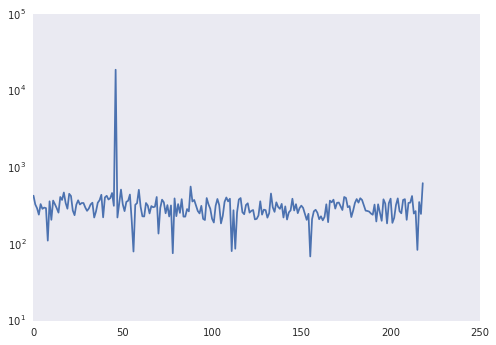

In [9]:
plot.plot(np.array(range(timeseries_len)), timeseries_values)
plot.yscale('log')
plot.grid()

# Anomaly Detection

A visual inspection of the chart above highlights the obvious anomalies, but we want to construct something that can automatically inspect the data, learn from it, and detect anomalies in an automated way.

## Anomaly Detector

The code below is a simple anomaly detector created for purposes of a sample. It uses simple algorithm of tracking mean and standard deviation. You can give it a value indicating # of instances it uses to train a model before it starts detecting anomalies. As new values are passed to this, it continues to update the model (to account for slow-evolving changes), in addition to reporting anomalies. Any value that is off from the mean by 3x the standard deviation is considered as an anomaly.

In [10]:
class AnomalyDetector(object):

  def __init__(self, window = 10):
    self._index = 0
    self._window = window
    self._values = np.zeros(window)
    self._valuesSq = np.zeros(window)
    self._mean = 0
    self._variance = 0
    self._count = 0

  def observation(self, value):
    anomaly = False

    threshold = 3 * np.sqrt(self._variance)
    if self._count > self._window:
      if value > self._mean + threshold:
        value = self._mean + threshold
        anomaly = True
      elif value < self._mean - threshold:
        value = self._mean - threshold
        anomaly = True
    else:
      self._count += 1

    prev_value = self._values[self._index]
    self._values[self._index] = value
    self._valuesSq[self._index] = value ** 2
    self._index = (self._index + 1) % self._window

    self._mean = self._mean - prev_value / self._window + value / self._window
    self._variance = sum(self._valuesSq) / self._window - (self._mean ** 2)

    return anomaly, self._mean

With the anomaly detector implemented, lets run the timeseries through this anomaly detector, to collect any anomalies, as well as expected mean along each point.

In [11]:
anomalies = np.zeros(timeseries_len)
means = np.zeros(timeseries_len)

anomaly_detector = AnomalyDetector(36)

for i, value in enumerate(timeseries_values):
  anomaly, mean = anomaly_detector.observation(value)
    
  anomalies[i] = anomaly
  means[i] = mean

And then plot the same time series, but overlay the anomalies, and the mean values as well.

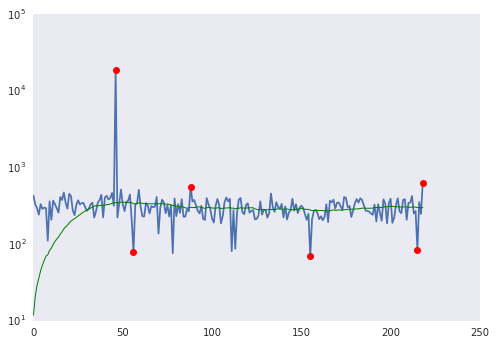

In [12]:
ticks = np.array(range(timeseries_len))

plot.plot(ticks, timeseries_values)
plot.plot(ticks[anomalies == 1], timeseries_values[anomalies == 1], 'ro')
plot.plot(ticks, means, 'g', linewidth = 1)
plot.yscale('log')
plot.grid()

# Going Beyond the Sample

This sample demonstrated using SQL to transform raw log data into an interesting timeseries, and then applying some Python logic to detect and visualize anomalies.

In terms of next steps, here are some that would start making this more useful.

* Build an initial model based on training data over a representative time, and store that model.

* Parameterize the source table of the logs. You'll want to use a table that is date-based, and use a table decorater to convert the last N minutes of log data into a single timeseries point.

* Pass the resulting timeseries point into an anomaly detector that uses the stored model, which would then like publish anomalies to a pub/sub topic.

The notebook allows you to work with your data to explore it, understand it and work through the steps of creating derived data, into a proof of concept that you can then take to build the final solution.